In [1]:
path = 'Data/preprocessed'

In [2]:
from nilearn.glm.first_level import make_first_level_design_matrix
import matplotlib.pyplot as plt
import nibabel as nib
import nilearn as ni
import pandas as pd
import numpy as np
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting

## load Data

In [3]:
t1 = nib.load(f"{path}/sub-05_desc-brain.nii.gz")
fmri1_loc = nib.load(f"{path}/sub-05_task-rest_run-2_space-T1w_desc-preproc_bold.nii.gz")
mean_img = nib.Nifti1Image(t1.get_fdata(), t1.affine, header=t1.header)

t1_data = t1.get_fdata()
bold_data = fmri1_loc.get_fdata()

print('T1w shape:', t1_data.shape)
print('BOLD shape:', bold_data.shape)

T1w shape: (176, 256, 256)
BOLD shape: (78, 92, 74, 250)


## Event Matrix generation

In [4]:
# Parameters
TR = 2.5  # Repetition time in seconds
num_volumes = 250  # Total number of volumes
block_duration = 25  # Block duration in seconds
task_start_time = 32.25  # Task starts after 32.25 seconds
total_time = num_volumes * TR  # Total fMRI scan time

# Time points corresponding to each volume
onset_times = np.arange(0, total_time, TR)

# Initialize the design matrix with zeros and add a duration column
events_matrix = pd.DataFrame({'onset': onset_times, 
                              'trial_type': np.zeros(len(onset_times), dtype=object),
                              'duration': np.ones(len(onset_times)) * TR})  # Each volume is TR seconds long

# Loop through time points and alternate task blocks between Rest, K, M, and P
current_time = task_start_time
task_state = 'M'  # Start with Task_Block M

while current_time < total_time:
    block_end_time = current_time + block_duration
    if block_end_time > total_time:  # Make sure we don't go beyond the fMRI duration
        block_end_time = total_time

    # Set the task block to the current task state (alternating Rest, K, M, and P)
    events_matrix.loc[(events_matrix['onset'] >= current_time) & (events_matrix['onset'] < block_end_time), 'trial_type'] = task_state

    # Alternate task state between Rest, K, M, and P
    task_state = {'Rest': 'K', 'K': 'M', 'M': 'P', 'P': 'Rest'}[task_state]
    
    # Move to the next block
    current_time = block_end_time
    
events_matrix.loc[num_volumes-7:,'trial_type'] = 0
events_matrix['trial_type'] = events_matrix['trial_type'].astype(str)

events_matrix.head(20)

,onset,trial_type,duration
0,0.0,0,2.5
1,2.5,0,2.5
2,5.0,0,2.5
3,7.5,0,2.5
4,10.0,0,2.5
5,12.5,0,2.5
6,15.0,0,2.5
7,17.5,0,2.5
8,20.0,0,2.5
9,22.5,0,2.5


## Design matrix

,0,0_derivative,0_dispersion,K,K_derivative,K_dispersion,M,M_derivative,M_dispersion,P,...,drift_4,drift_5,drift_6,drift_7,drift_8,drift_9,drift_10,drift_11,drift_12,constant
0.0,0.000000,0.000000,1.043679e-17,0.0,0.0,0.0,0.0,0.0,5.985426e-17,0.0,...,0.089414,0.089399,0.089379,0.089356,0.089330,0.089300,0.089266,0.089229,0.089189,1.0
2.5,0.061408,0.101903,-1.133123e-01,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,...,0.089189,0.089046,0.088871,0.088665,0.088428,0.088159,0.087858,0.087527,0.087164,1.0
5.0,0.706961,0.339103,-9.685093e-02,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,...,0.088737,0.088342,0.087858,0.087289,0.086633,0.085891,0.085065,0.084155,0.083162,1.0
7.5,1.408667,0.159160,1.665529e-01,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,...,0.088062,0.087289,0.086346,0.085237,0.083963,0.082526,0.080930,0.079177,0.077272,1.0
10.0,1.542688,-0.052930,6.276156e-02,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,...,0.087164,0.085891,0.084344,0.082526,0.080445,0.078107,0.075519,0.072690,0.069628,1.0


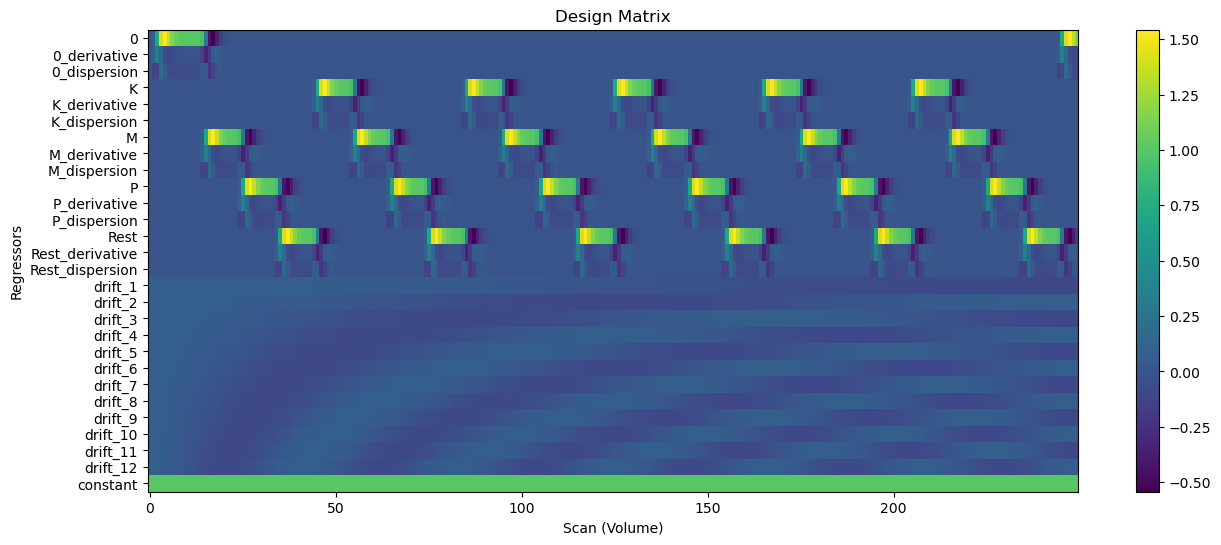

In [5]:
dsgn_mx1 = make_first_level_design_matrix(
    np.arange(fmri1_loc.shape[-1]) * TR,
    events=events_matrix,
    drift_model='cosine',
    hrf_model="glover + derivative + dispersion"
)

display(dsgn_mx1.head())
plt.figure(figsize=(15, 6))
plt.imshow(dsgn_mx1.T, aspect='auto', interpolation='nearest')
plt.xlabel('Scan (Volume)')
plt.yticks(ticks=np.arange(dsgn_mx1.shape[1]), labels=dsgn_mx1.columns)
plt.ylabel('Regressors')
plt.title('Design Matrix')
plt.colorbar()
plt.show()

## Drop confounders + fit GLM

In [6]:
confound_vars = [
    'csf', 'white_matter', 'global_signal',
    'framewise_displacement',
    't_comp_cor_00', 't_comp_cor_01', 't_comp_cor_02',
    'trans_x', 'trans_y', 'trans_z',
    'rot_x', 'rot_y', 'rot_z'
]

In [7]:
confounds_path = f"{path}/sub-05_task-rest_run-2_desc-confounds_timeseries.tsv"
confounds_df = pd.read_csv(confounds_path, sep='\t')

# Optional: fill NaNs (especially in FD)
confounds_df.bfill(inplace=True)

# Select confounds (adjust based on your needs)
selected_confounds = confounds_df[confound_vars]

# Ensure same number of timepoints
assert selected_confounds.shape[0] == fmri1_loc.shape[-1]

# Add to model
fmri_glm1 = FirstLevelModel(
    smoothing_fwhm=5,
    minimize_memory=False,
    drift_model='cosine',
    # hrf_model="glover + derivative + dispersion"
)

fmri_glm1 = fmri_glm1.fit(
    fmri1_loc,
    design_matrices=dsgn_mx1,
    # confounds=selected_confounds
)

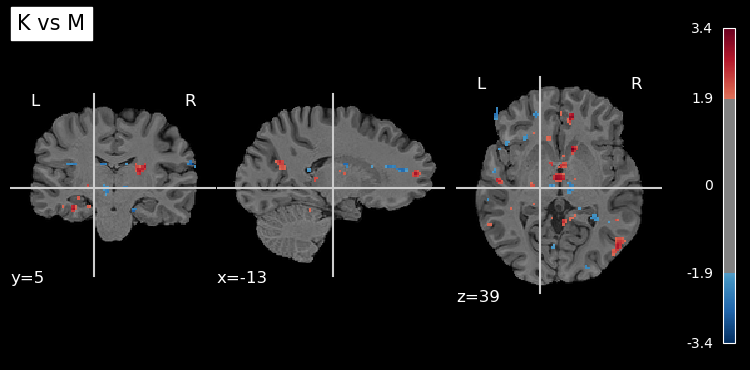

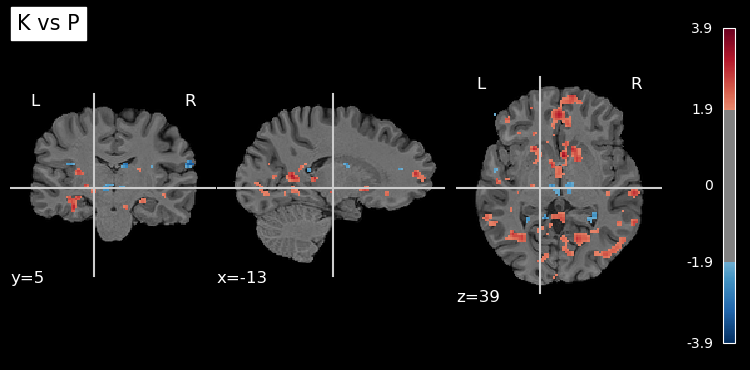

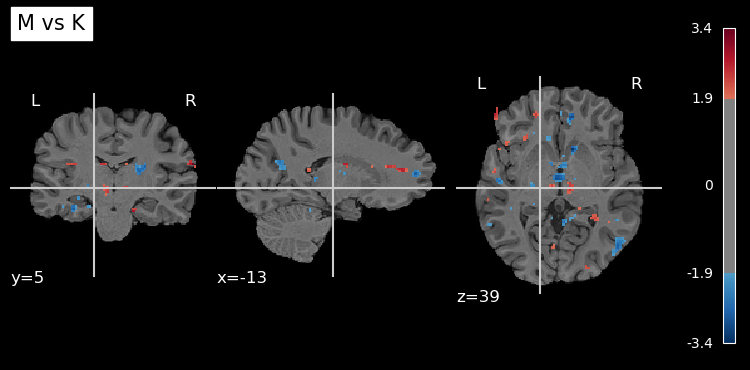

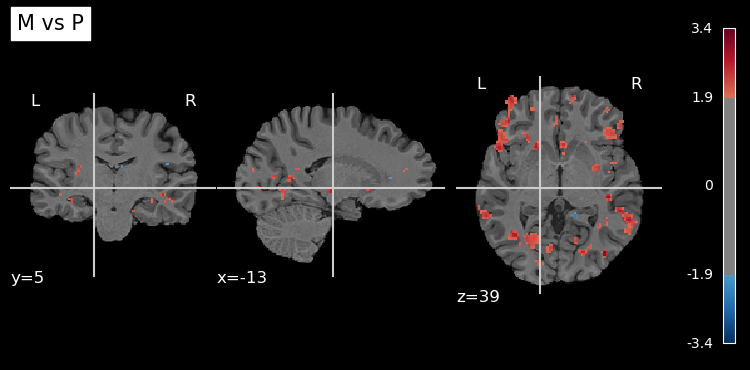

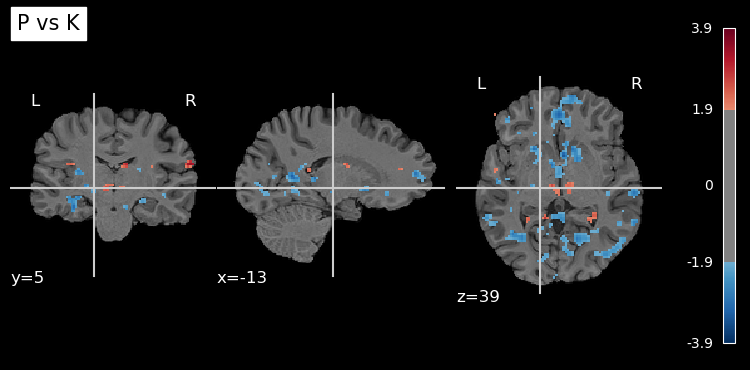

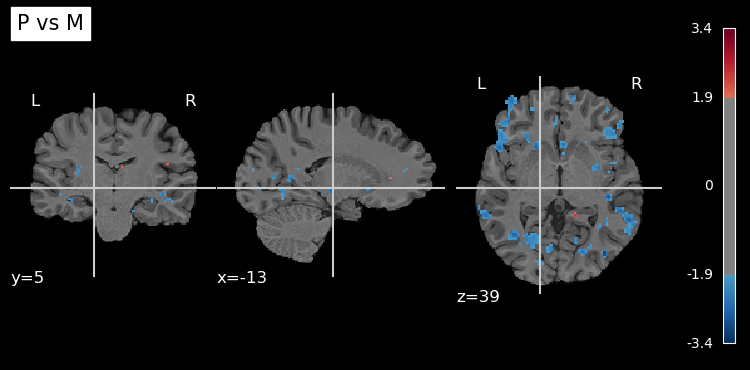

In [8]:
import itertools

pairs_zscores = {}

for pair in itertools.permutations(['K', 'M', 'P'], 2):
    contrast_val1 = dsgn_mx1.columns.str.contains(pair[0]).astype(int) - dsgn_mx1.columns.str.contains(pair[1]).astype(int)
    summary_statistics_session1 = fmri_glm1.compute_contrast(contrast_val1, output_type='all')
    pairs_zscores[pair] = nib.Nifti1Image(summary_statistics_session1['z_score'].get_fdata(), summary_statistics_session1['z_score'].affine)

    plotting.plot_stat_map(
        summary_statistics_session1['z_score'],
        bg_img=mean_img,
        cut_coords=(-13.21, 5.51, 39.30),
        threshold=1.9,
        title=f'{pair[0]} vs {pair[1]}'
    )

## Data cleaning

In [9]:
from scipy.ndimage import map_coordinates

def resample_to_target(source_nii, target_nii, order=1):
    """
    Resample a source NIfTI image to match the space (affine and shape) of a target image.
    Parameters:
        source_nii: nib.Nifti1Image
            The source image to be resampled.
        target_nii: nib.Nifti1Image
            The target image providing the reference space.
        order: int
            Interpolation order: 0 (nearest), 1 (linear), etc.
    Returns:
        numpy.ndarray
            The resampled source data in the target space.
    """
    source_data = source_nii.get_fdata()
    source_affine = source_nii.affine

    target_shape = target_nii.shape
    target_affine = target_nii.affine

    # Create a grid of voxel coordinates in the target space
    target_grid = np.meshgrid(
        np.arange(target_shape[0]),
        np.arange(target_shape[1]),
        np.arange(target_shape[2]),
        indexing='ij'
    )

    # Flatten the voxel grid to a 4xN matrix
    target_vox_coords = np.vstack([
        target_grid[0].ravel(),
        target_grid[1].ravel(),
        target_grid[2].ravel(),
        np.ones(np.prod(target_shape))
    ])

    # Convert voxel coordinates to world coordinates (RAS)
    target_world_coords = target_affine @ target_vox_coords

    # Convert world coordinates to source voxel coordinates
    inv_source_affine = np.linalg.inv(source_affine)
    source_vox_coords = inv_source_affine @ target_world_coords

    # Sample source data at target voxel coordinates
    resampled_flat = map_coordinates(
        source_data,
        source_vox_coords[:3],
        order=order,
        mode='constant',
        cval=0
    )

    # Reshape the flat result to the target shape
    resampled_data = resampled_flat.reshape(target_shape)

    return resampled_data

def apply_lgn_mask_on_zscore(zscore, lgn_path):
    """
    Resample a z-score image to match LGN mask space and apply the LGN mask.
    Saves the masked output to the given path.
    """
    # Load z-score and LGN images
    lgn_nii = nib.load(lgn_path)

    # Clean z-score data (remove NaNs and negative values)
    zscore_data = zscore.get_fdata()
    zscore_data[np.isnan(zscore_data)] = 0
    zscore_data[zscore_data < 0] = 0

    # Resample the z-score image to match the LGN mask space
    zscore_resampled = resample_to_target(zscore, lgn_nii, order=1)

    # Generate binary LGN mask
    lgn = lgn_nii.get_fdata()
    lgn_mask = (lgn > 0.5).astype(np.float32)

    # Apply the LGN mask on the resampled z-score data
    masked_data = zscore_resampled * lgn_mask

    # Save the result to the specified output path
    masked_nii = nib.Nifti1Image(masked_data, lgn_nii.affine, lgn_nii.header)
    return masked_nii

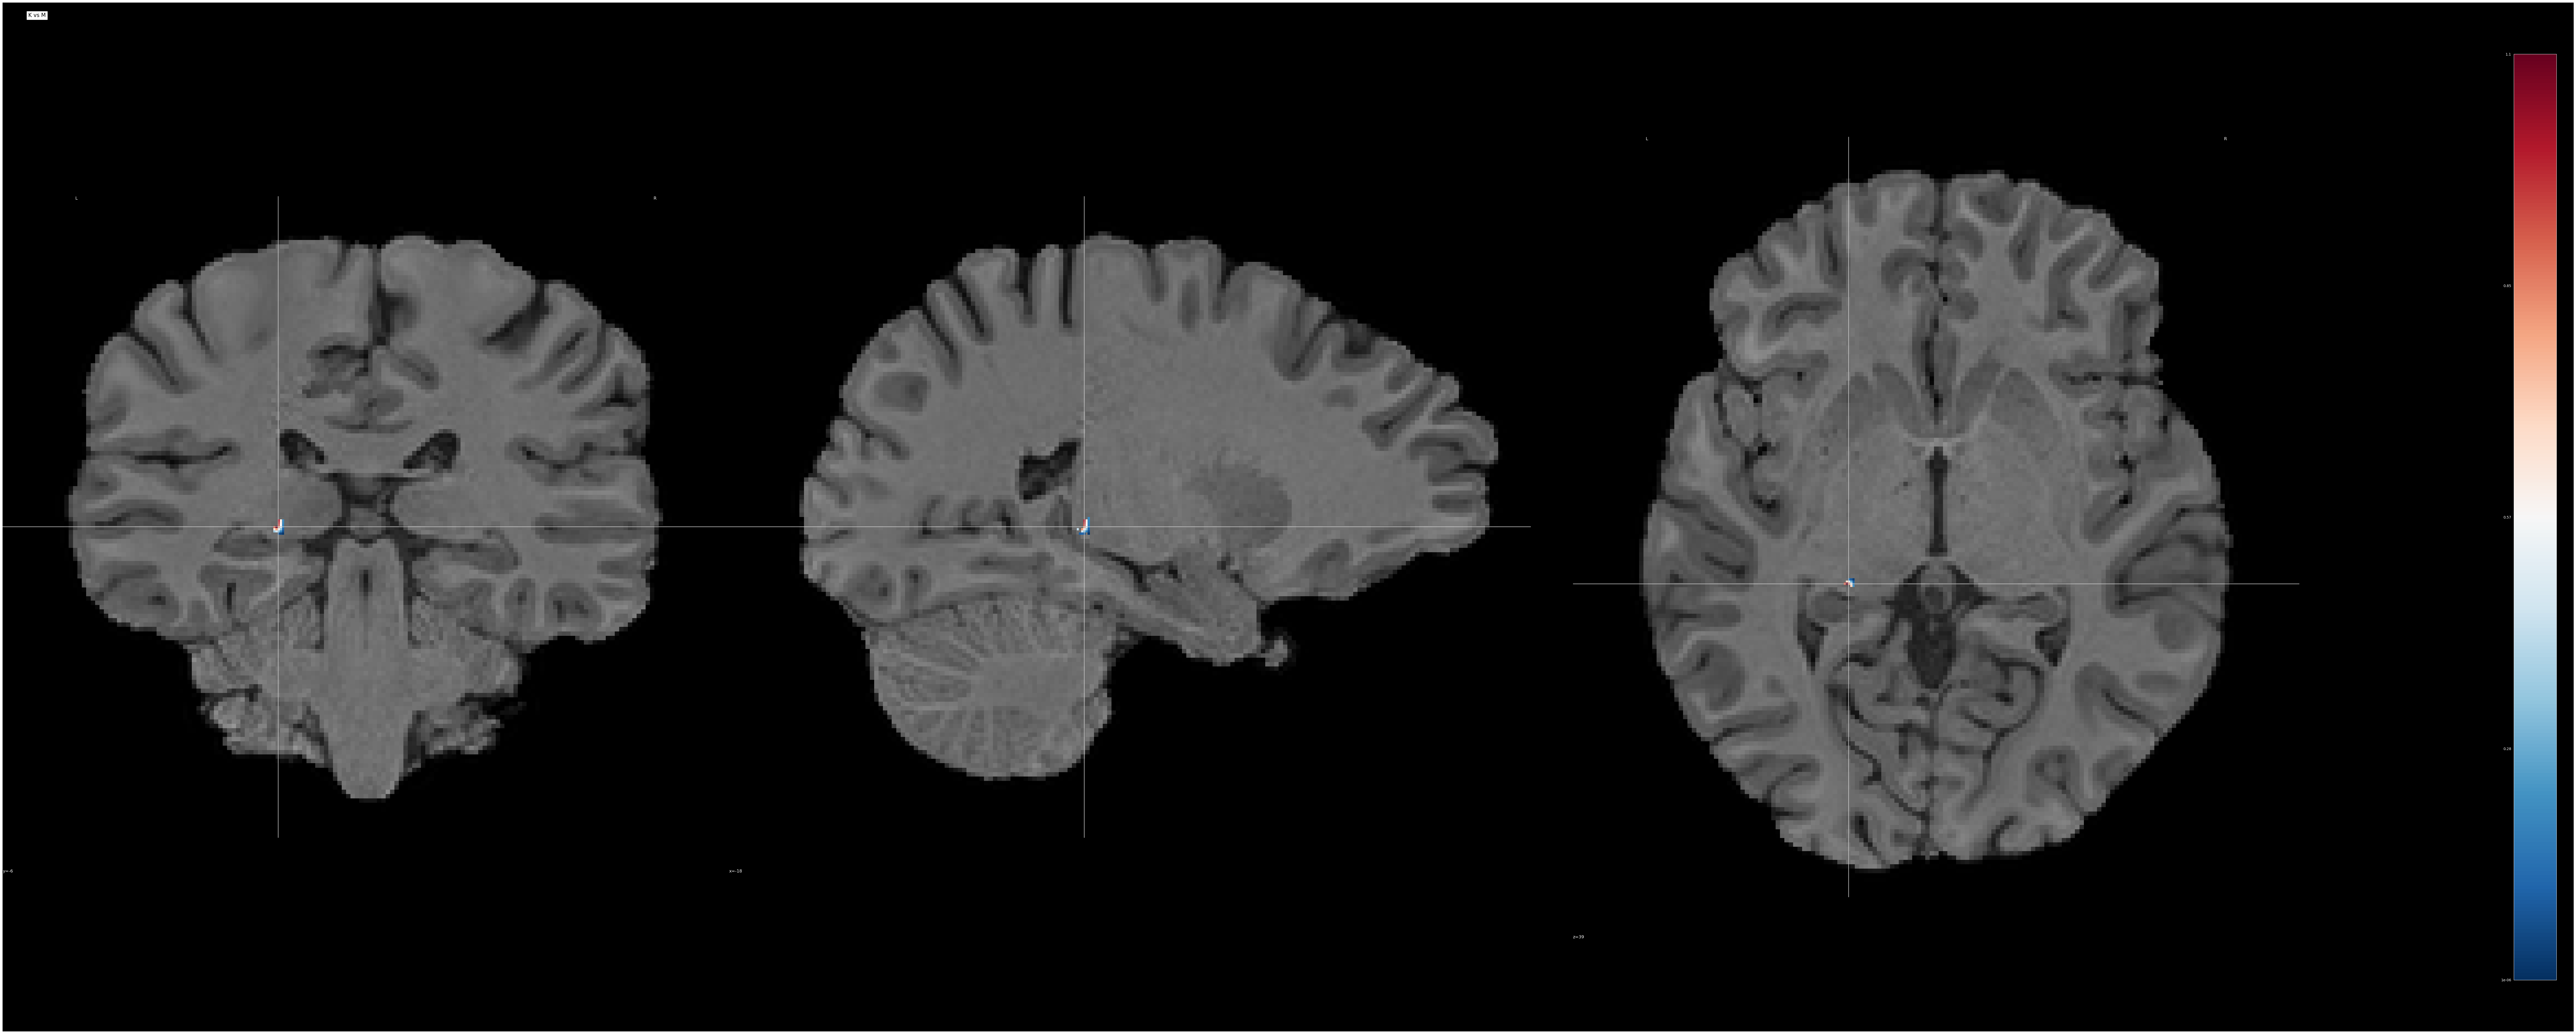

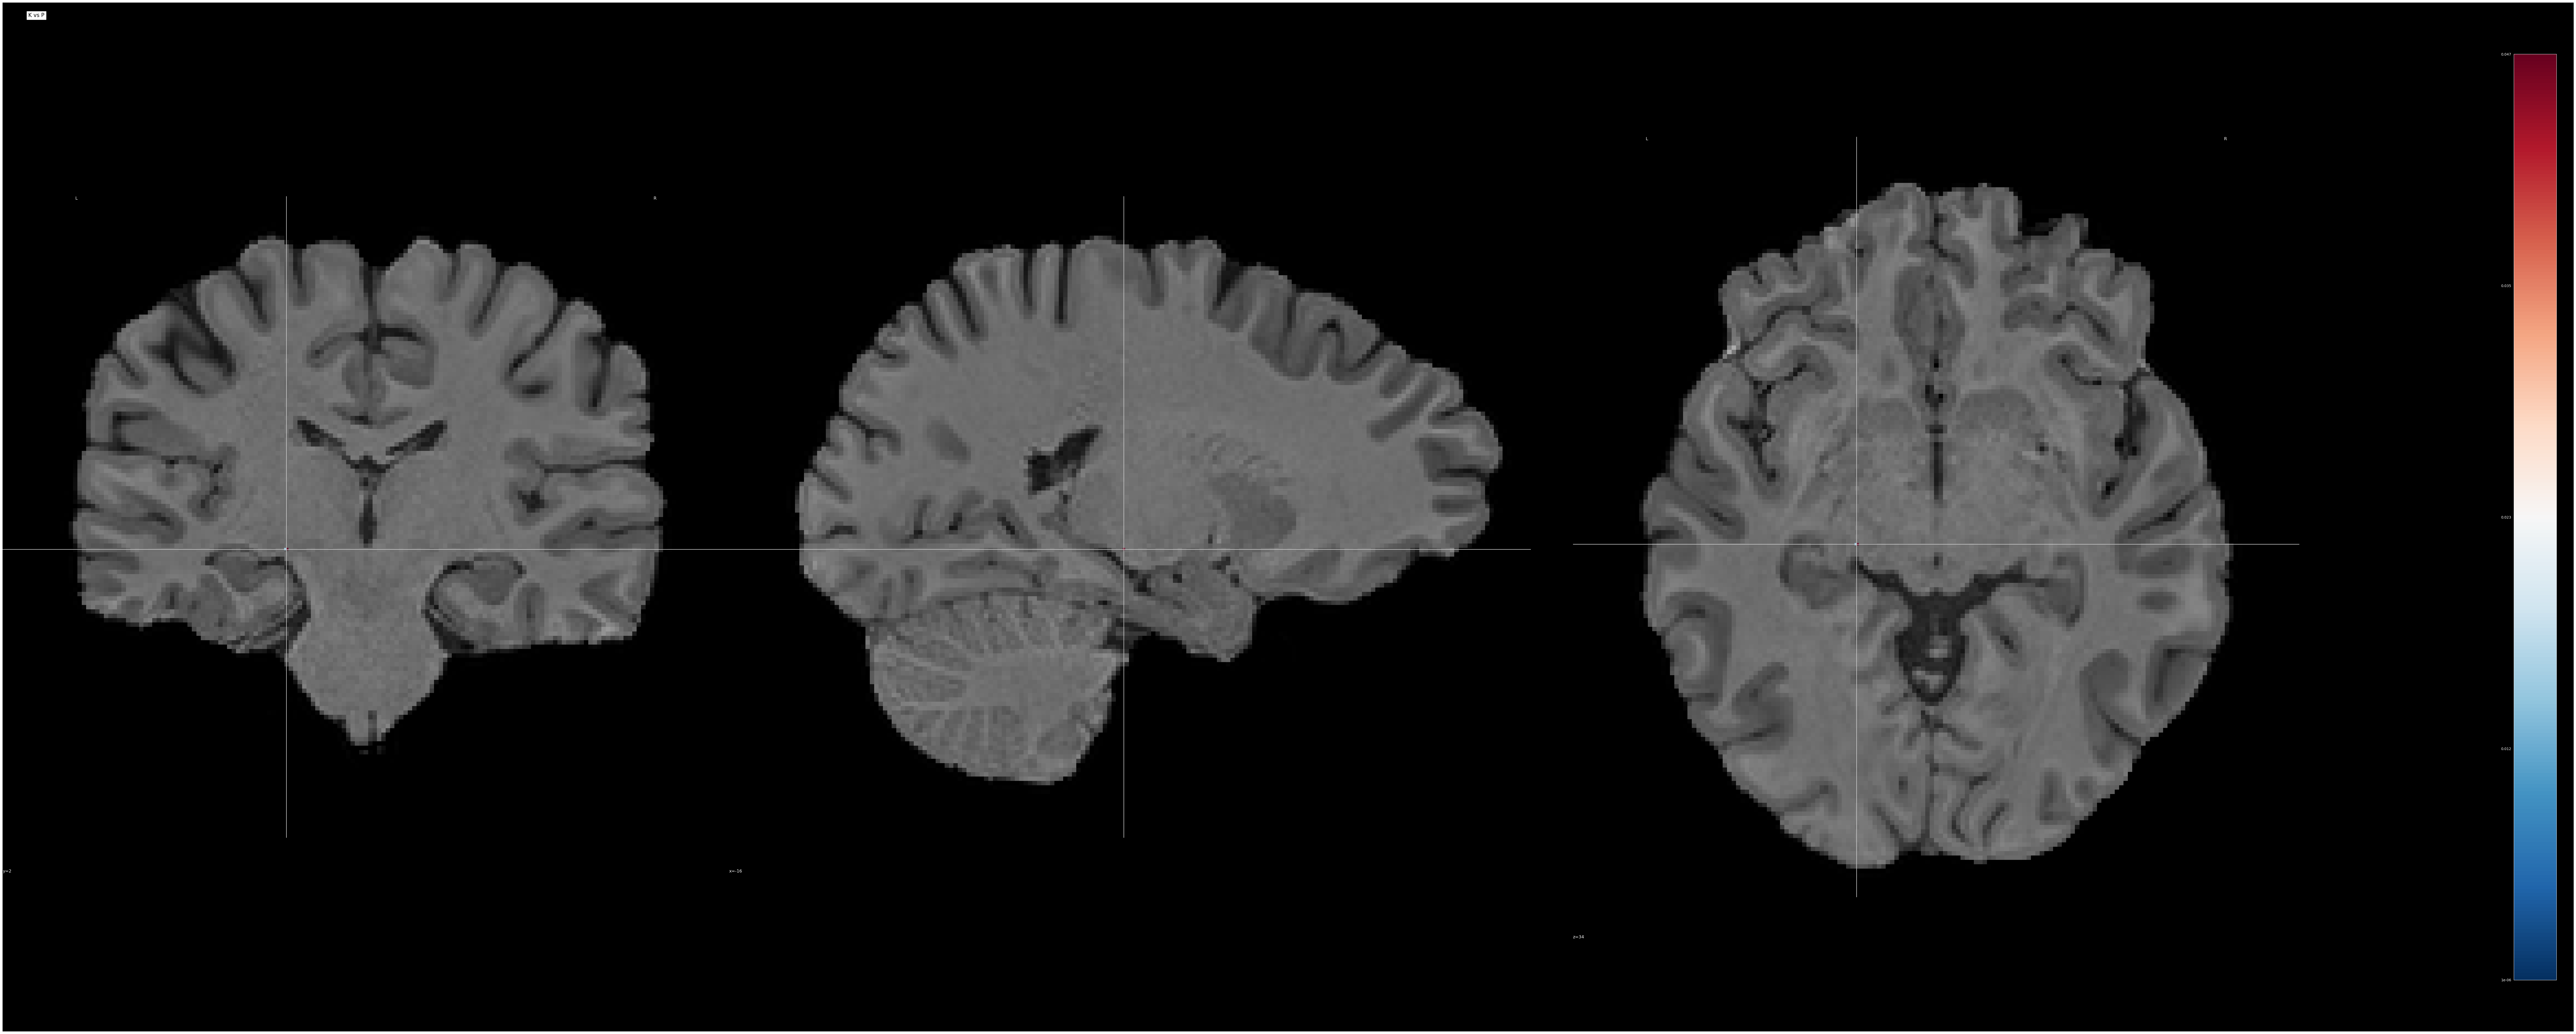

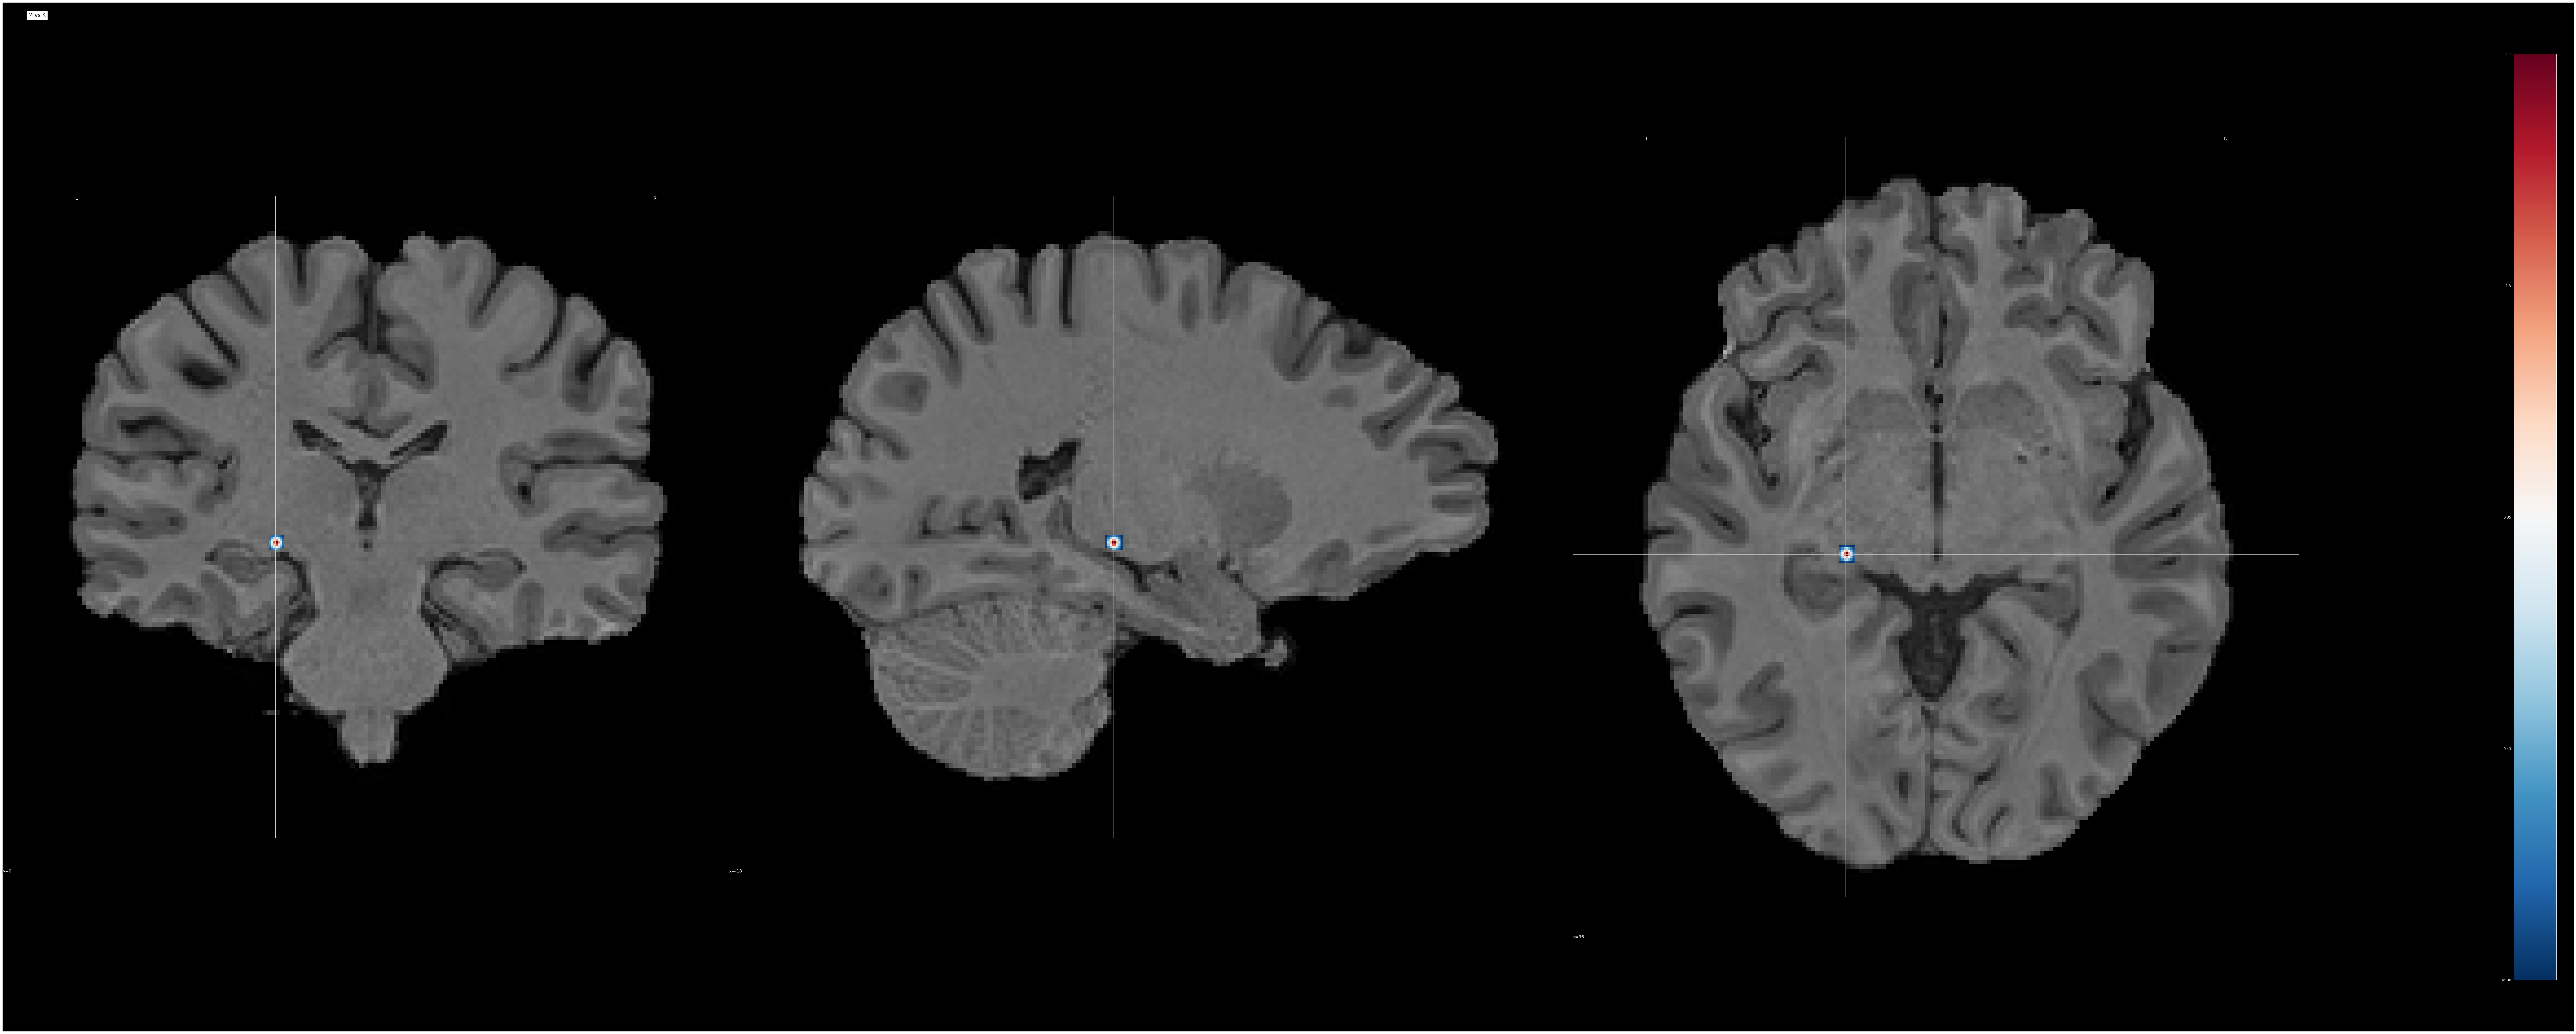

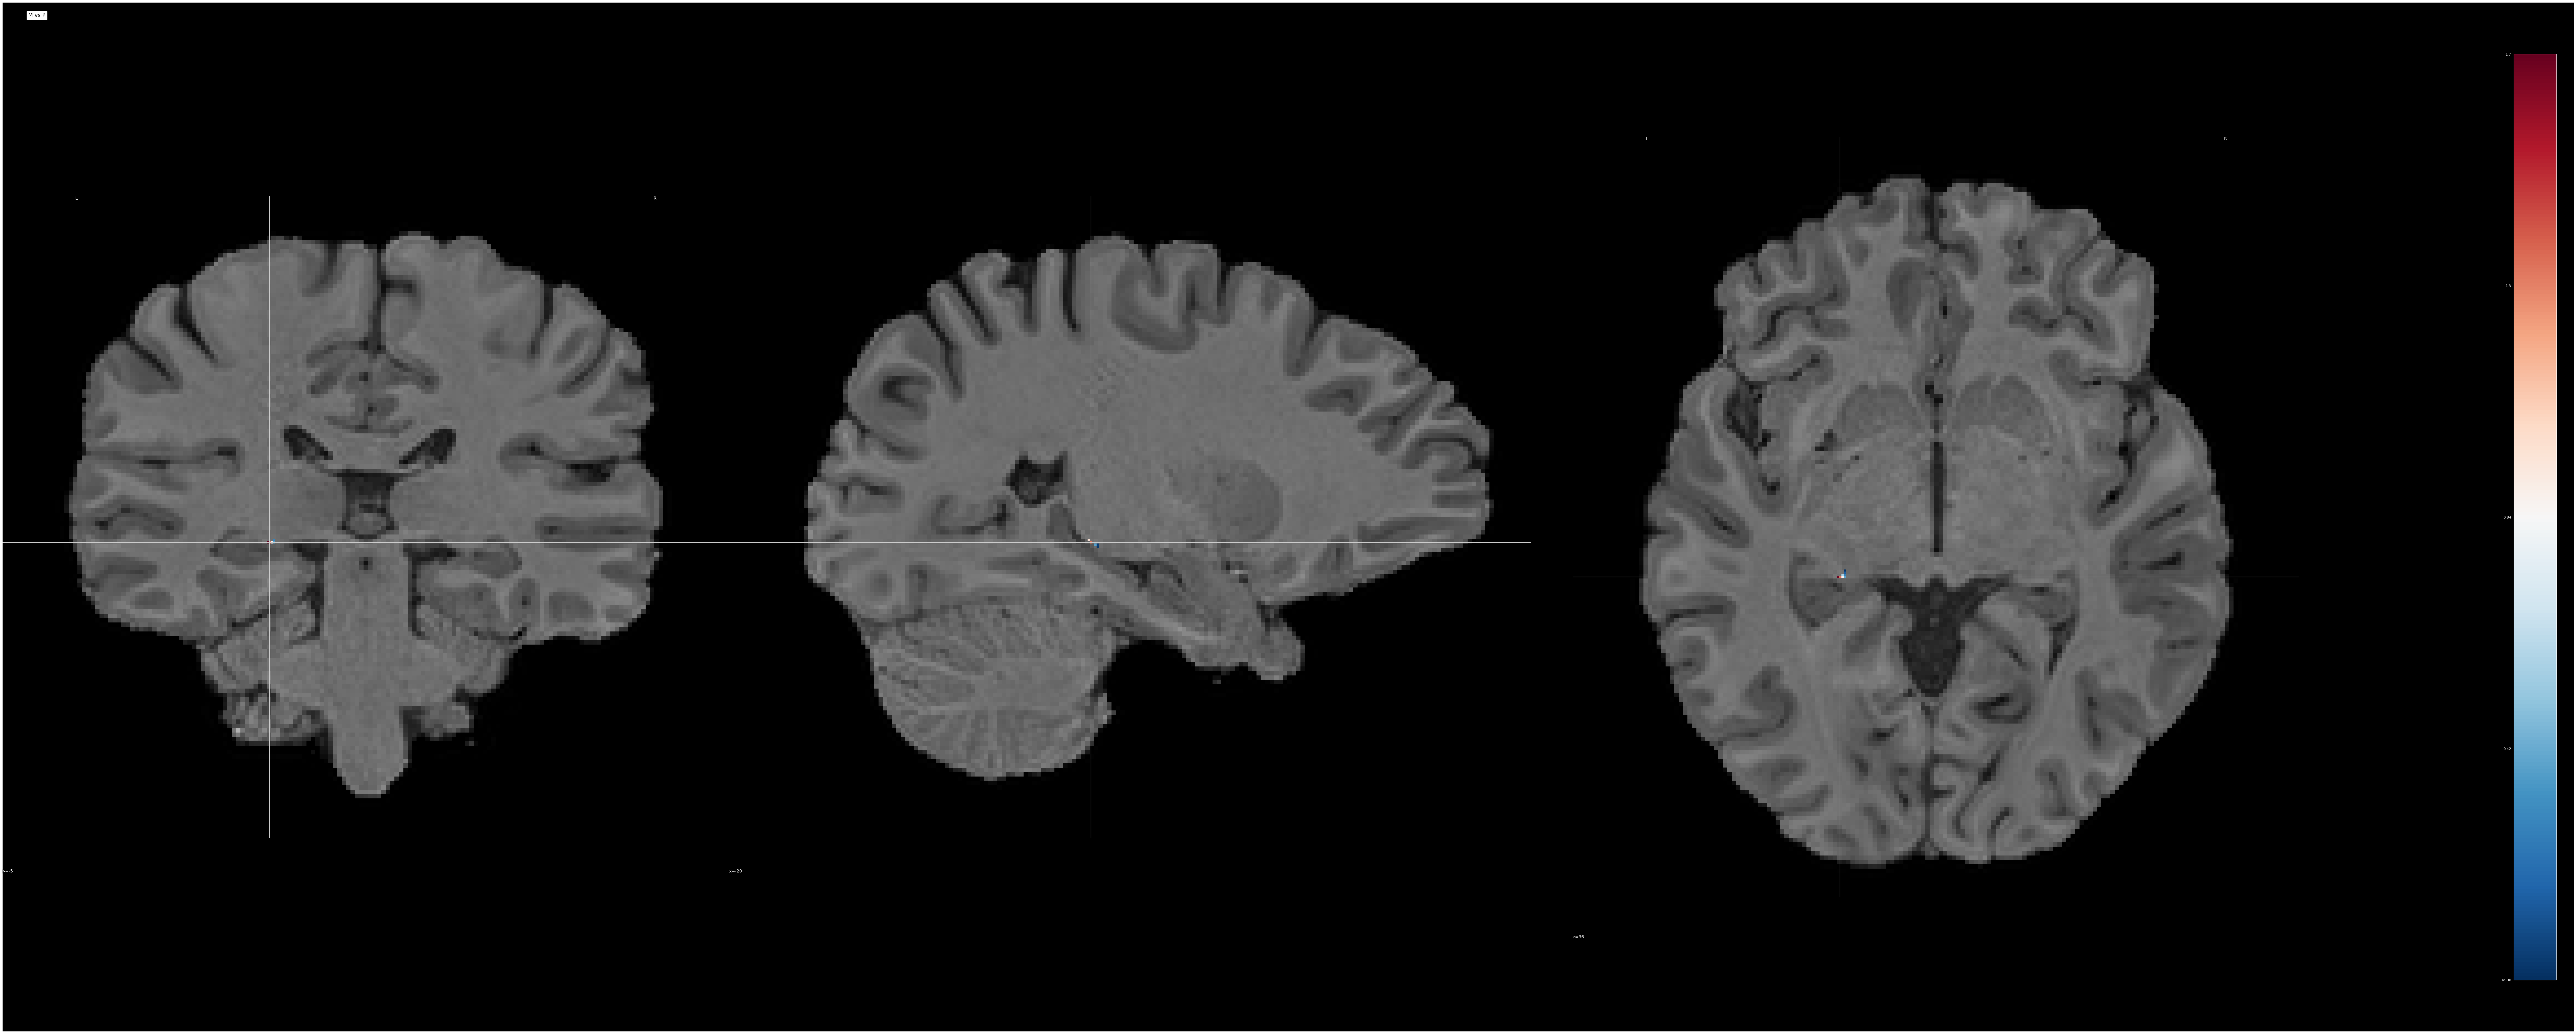

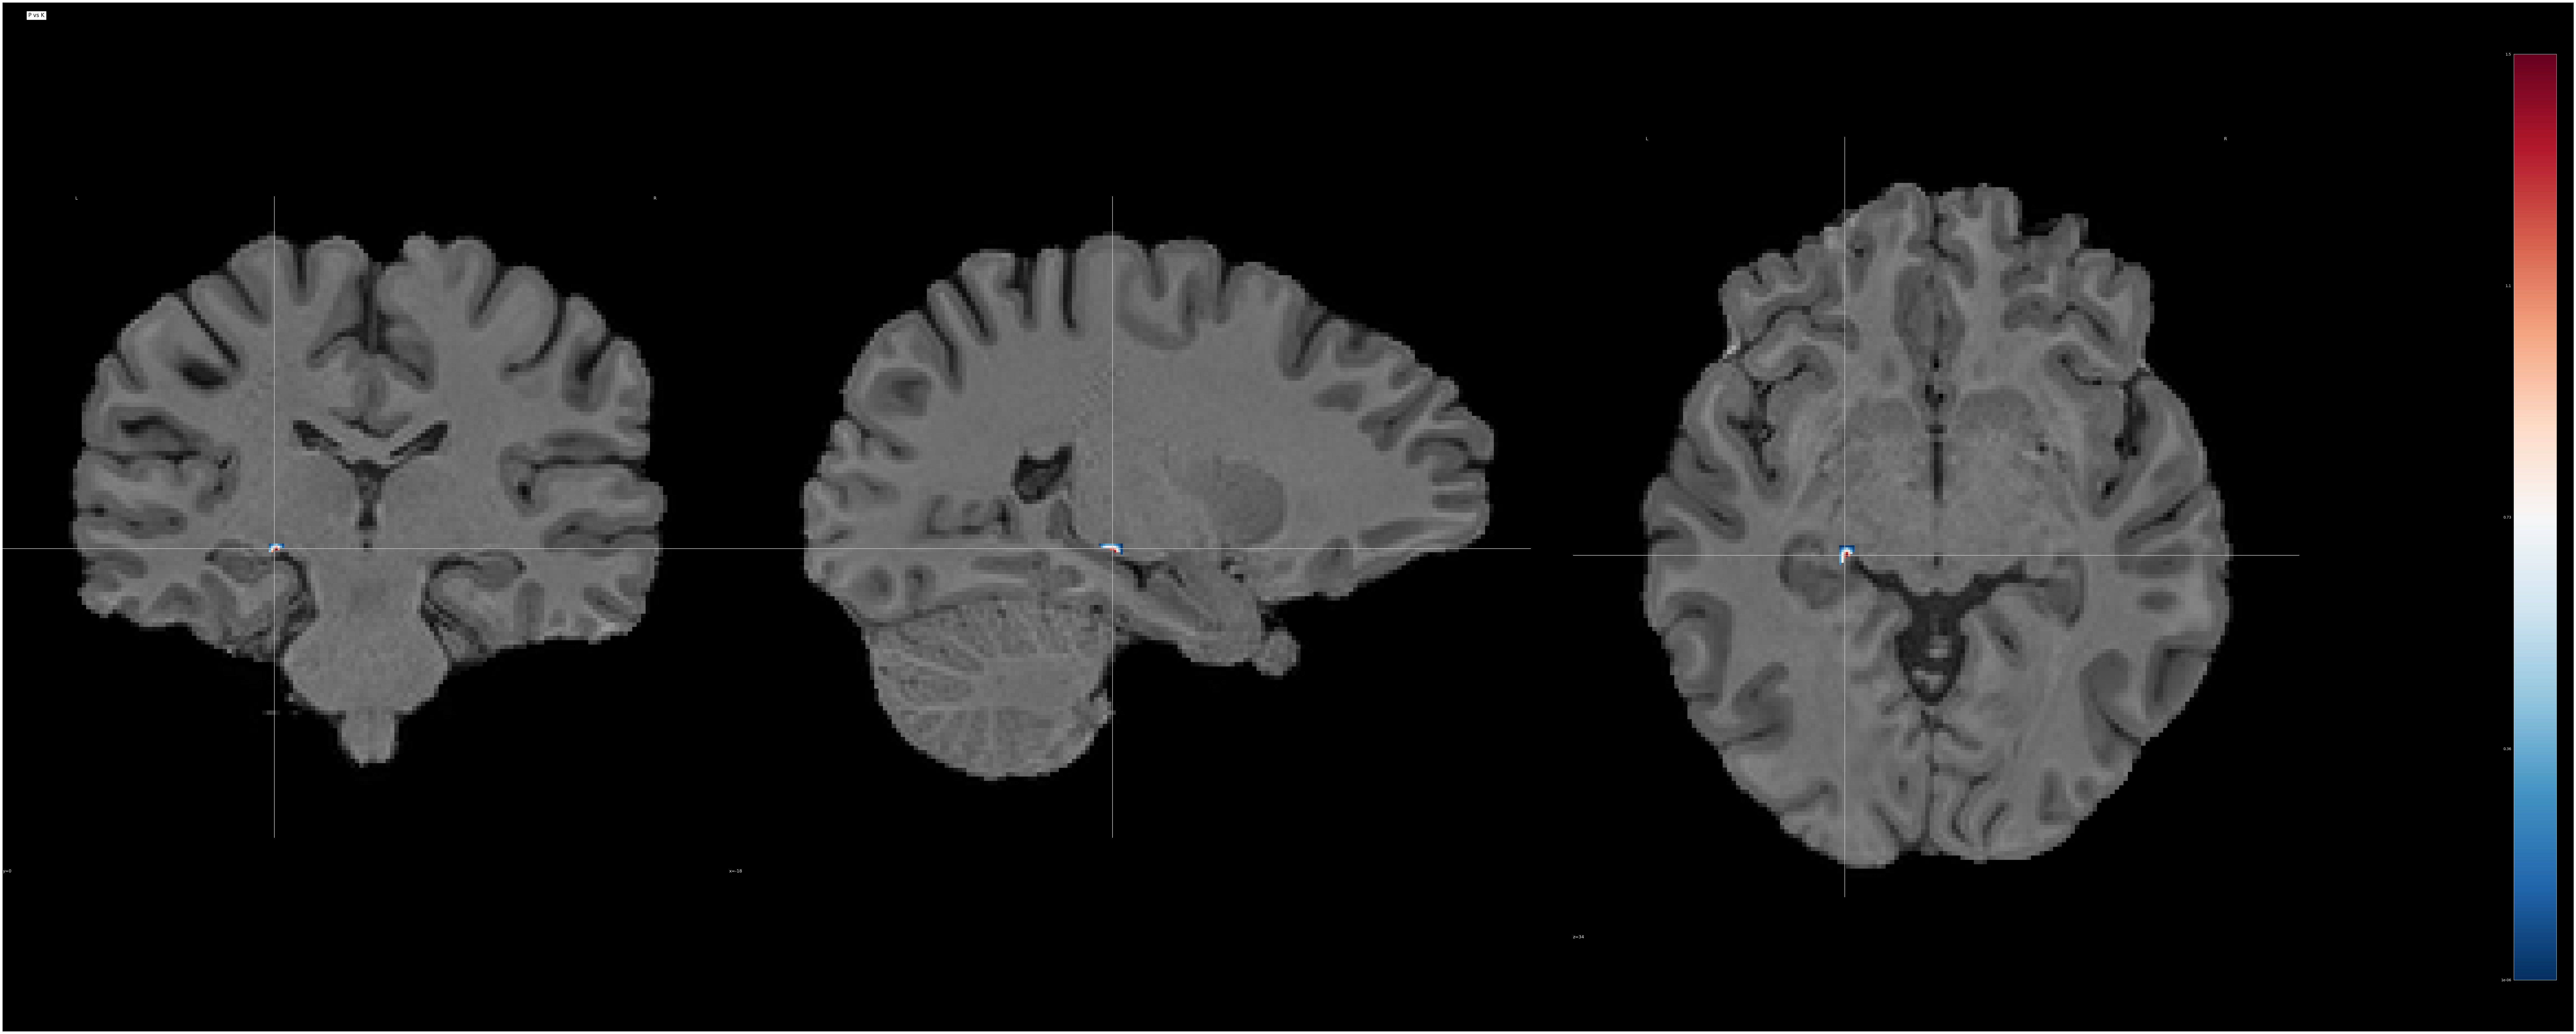

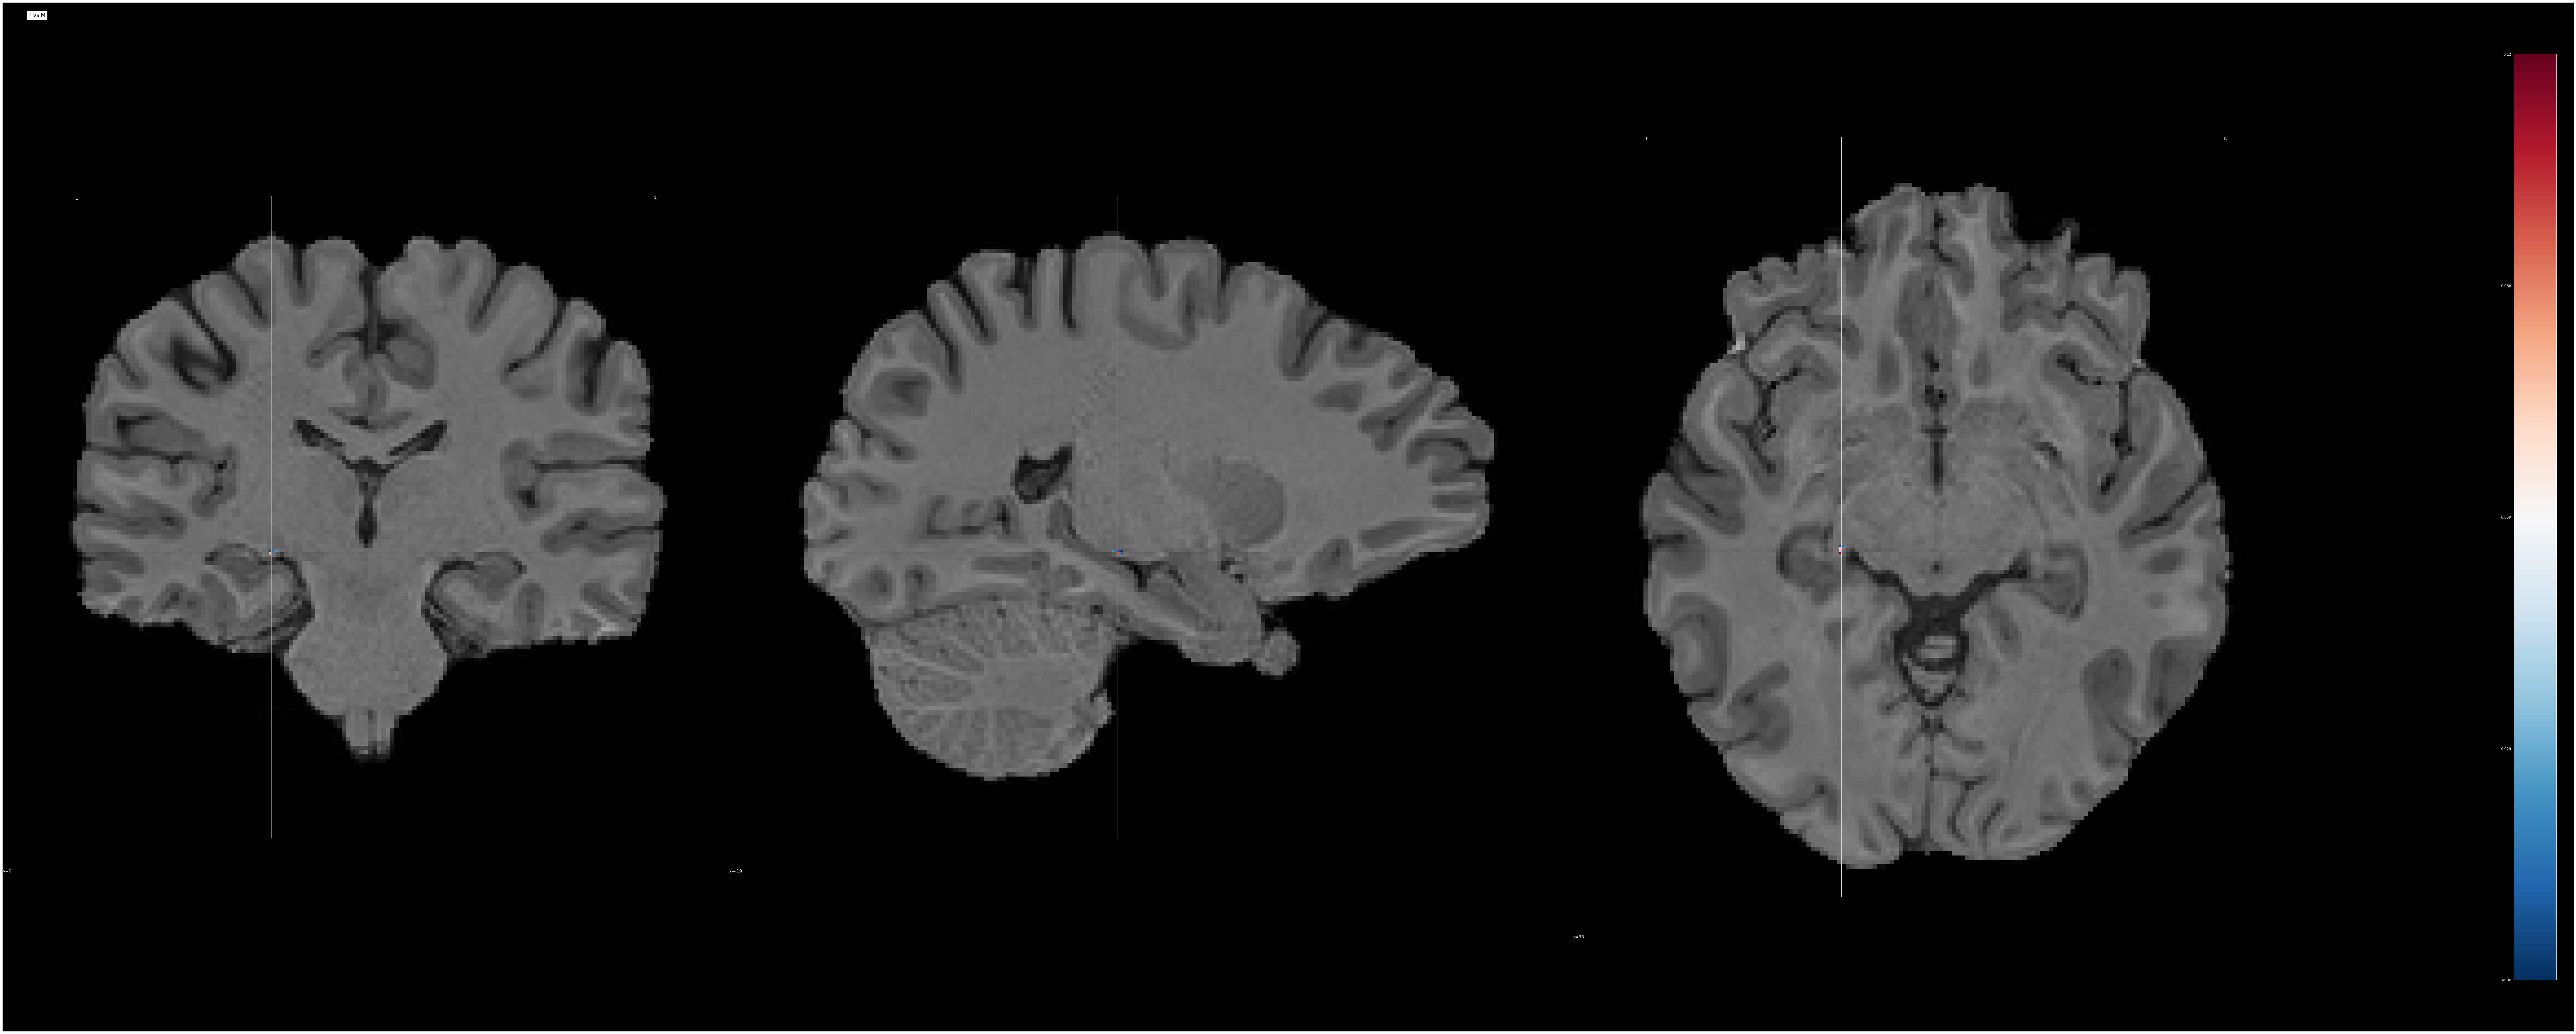

In [10]:
threshold = 1.96  # Change this based on your needs

for pair in pairs_zscores:
    contrast_data = pairs_zscores[pair]
    z_scores = contrast_data.get_fdata()

    # Apply threshold
    thresholded = np.where(np.abs(z_scores) >= threshold, z_scores, 0)
    z_scores_thresholded = nib.Nifti1Image(thresholded, contrast_data.affine, contrast_data.header)

    masked_img = apply_lgn_mask_on_zscore(
        zscore=z_scores_thresholded,
        lgn_path=f'{path}/ROIs/lh_LGN.nii.gz',
    )

    plotting.plot_stat_map(masked_img, bg_img=mean_img, title=f'{pair[0]} vs {pair[1]}', figure=plt.figure(figsize=(100, 40)))    